## Class aggregation

# Access harmonized LUCAS samples
First of all, let's install `st_lucas` Python package. 

Unfortunately Google Colab comes with GDAL 2.2. We have to update this library to version 3.0. It will takes a while.

In [1]:
!add-apt-repository --yes ppa:ubuntugis/ubuntugis-unstable
!apt update
!apt install python3-gdal libsqlite3-mod-spatialite 
!pip install gdal==3.0.4
print("INSTALLATION COMPLETED")

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:8 http://ppa.launchpad.net/ubuntugis/ubuntugis-unstable/ubuntu bionic InRelease [20.8 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804

In [2]:
!pip install owslib
!pip install -e 'git+https://gitlab.com/geoharmonizer_inea/st_lucas/st_lucas-python-package.git@colab#egg=st_lucas'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 217 kB 11.2 MB/s 
     |████████████████████████████████| 6.3 MB 21.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining st_lucas from git+https://gitlab.com/geoharmonizer_inea/st_lucas/st_lucas-python-package.git@colab#egg=st_lucas
  Cloning https://gitlab.com/geoharmonizer_inea/st_lucas/st_lucas-python-package.git (to revision colab) to ./src/st-lucas
  Running command git clone -q https://gitlab.com/geoharmonizer_inea/st_lucas/st_lucas-python-package.git /content/src/st-lucas
  Running command git checkout -b colab --track origin/colab
  Switched to a new branch 'colab'
  Branch 'colab' set up to track remote branch 'colab' from 'origin'.
     |████████████████████████████████| 1.0 MB 7.2 MB/s 
     |████████████████████████████████| 202 kB 69.7 MB/s 
     |██████████████████████████

Now **we have to restart runtime**: `Runtime -> Restart runtime`.

From `st_lucas` package let's import `LucasRequest` and `LucasIO`.

In [1]:
from st_lucas import LucasRequest, LucasIO, LucasClassAggregate

#### Define request

Request LUCAS points located in the Czech Republic and surveyed in 2018.

In [2]:
request = LucasRequest()
request.countries = ['CZ']
request.years = [2018]

#### Download data

In [3]:
lucasio = LucasIO()
lucasio.download(request)

2022-06-13 14:36:44,469 - LUCAS - INFO - io.download - Download process successfuly finished. Size of downloaded data: 27381kb


#### Inspect downloaded LUCAS data

In [4]:
df = lucasio.to_geopandas()
df[["point_id","lc1"]]

2022-06-13 14:36:56,032 - numexpr.utils - INFO - utils._init_num_threads - NumExpr defaulting to 2 threads.


,point_id,lc1
0,46142892,C10
1,48462894,A30
2,48042992,A30
3,46142990,A30
4,46582898,A22
...,...,...
5708,46382866,A11
5709,48042952,A11
5710,48642994,G11
5711,47002938,A12


In [5]:
df.count()

point_id         5713
nuts0            5713
nuts1            5713
nuts2            5713
nuts3            5713
                 ... 
crop_residues    5713
transect            0
ex_ante          5713
survey_year      5713
geometry         5713
Length: 116, dtype: int64

#### Show statistics

In [6]:
df["lc1"].describe()

count     5713
unique      57
top        E20
freq       990
Name: lc1, dtype: object

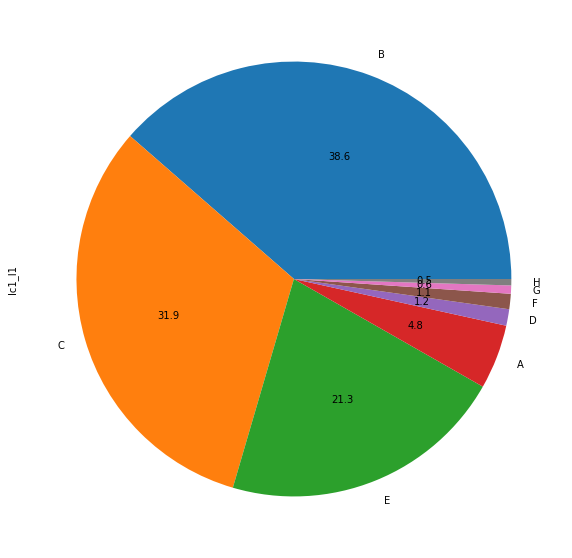

In [7]:
df['lc1_l1'] = df['lc1'].str.slice(0,1)
df['lc1_l1'].value_counts().plot.pie(figsize=(10, 10), autopct="%.1f")

#### Apply aggregation

LUCAS points are by default obtained with information corresponding to LUCAS land cover level 3. With the `LucasClassAggregate` method, you can get information about level 2 or level 1. New column will be added at the end of attribute table.

In [8]:
!dpkg -L libsqlite3-mod-spatialite

from st_lucas import LucasRequest, LucasIO, LucasClassAggregate
request = LucasRequest()
request.countries = ['CZ']
request.years = [2018]
lucasio = LucasIO()
lucasio.download(request)

lc1_to_level1 = {
    "A00": ["A11", "A12", "A13", "A21", "A22", "A30"],
    "B00": ["B11", "B12", "B13", "B14", "B15", "B16", "B17", "B18", "B19", "B21", "B22", "B23", "B31", "B32", "B33", "B34", "B35", "B36", "B37", "B41", "B42", "B43", "B44", "B45", "B51", "B52", "B53", "B54", "B55", "B71", "B72", "B73", "B74", "B75", "B76", "B77", "B81", "B82", "B83", "B84"],
    "Bx1": ["Bx1"],
    "Bx2": ["Bx2"],
    "C00": ["C10", "C21", "C22", "C23", "C31", "C32", "C33"],
    "D00": ["D10", "D20"],
    "E00": ["E10", "E20", "E30"],
    "F00": ["F10", "F20", "F30", "F40"],
    "G00": ["G11", "G12", "G21", "G22", "G30", "G40", "G50"],
    "H00": ["H11", "H12", "H21", "H22", "H23"]
}

lucasaggr = LucasClassAggregate(lucasio.data, mappings=lc1_to_level1)
# lucasaggr = LucasClassAggregate(lucasio.data, mappings_file='aggregation_lc1_h_to_level1.json')
lucasaggr.apply()

/.
/usr
/usr/lib
/usr/lib/x86_64-linux-gnu
/usr/lib/x86_64-linux-gnu/mod_spatialite.so.7.1.0
/usr/share
/usr/share/doc
/usr/share/doc/libsqlite3-mod-spatialite
/usr/share/doc/libsqlite3-mod-spatialite/NEWS.Debian.gz
/usr/share/doc/libsqlite3-mod-spatialite/changelog.Debian.gz
/usr/share/doc/libsqlite3-mod-spatialite/copyright
/usr/share/lintian
/usr/share/lintian/overrides
/usr/share/lintian/overrides/libsqlite3-mod-spatialite
/usr/lib/x86_64-linux-gnu/mod_spatialite.so
/usr/lib/x86_64-linux-gnu/mod_spatialite.so.7
2022-06-13 14:38:24,479 - LUCAS - INFO - io.download - Download process successfuly finished. Size of downloaded data: 27381kb


Check the appearance of the new column.

In [9]:
df = lucasio.to_geopandas()
df[["lc1_h", "lc1_a"]].head()


,lc1_h,lc1_a
0,C10,C00
1,A30,A00
2,A30,A00
3,A30,A00
4,A22,A00


## Nomenclature translation

Translate the obtained data into CLC2.

In [10]:
from st_lucas import LucasClassTranslate

lucastrans = LucasClassTranslate(lucasio.data)
lucastrans.set_translations("CLC2")
lucastrans.apply()

Check the appearance of the new column.

In [12]:
df = lucasio.to_geopandas()
df[["lc1_h", "lu1_h", "clc2"]].head(10)

,lc1_h,lu1_h,clc2
0,C10,U120,31
1,A30,U319,99
2,A30,U319,99
3,A30,U319,99
4,A22,U312,12
5,A22,U312,12
6,A30,U319,99
7,B75,U113,22
8,B75,U113,22
9,B71,U113,22
